### Introduction

This project focuses on emotion recognition from audio data using machine learning techniques. We utilize two prominent datasets: the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) and the Toronto Emotional Speech Set (TESS). These datasets provide a diverse range of emotional expressions captured through speech, which serve as the basis for our analysis.

The primary goal is to develop models that can accurately classify emotions based on audio features extracted from these datasets. We employ a variety of models, including traditional algorithms like K-Nearest Neighbors (KNN) and advanced deep learning architectures such as Convolutional Neural Networks (CNN) and hybrid CNN + LSTM models. Each model is evaluated to understand its effectiveness in capturing the nuances of emotional speech.

Through this exploration, we aim to identify the most suitable approach for emotion recognition tasks, leveraging the strengths of each model to improve classification accuracy. This work not only contributes to advancements in audio-based emotion recognition but also provides insights into the application of machine learning techniques in speech analysis.

In [1]:
!pip install moviepy

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import random
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

Here, we mount Google Drive to access files stored in it. This is essential because our dataset is stored in Google Drive, and mounting allows us to interact with these files directly from the notebook.

In [5]:
import os

path = '/content/gdrive/My Drive/1188976'
files = os.listdir(path)
print(files)

['Video_Speech_Actor_17', 'Video_Speech_Actor_18', 'Video_Speech_Actor_24', 'Video_Speech_Actor_16', 'Video_Speech_Actor_21', 'Video_Speech_Actor_22', 'Video_Speech_Actor_23', 'Video_Speech_Actor_20', 'Video_Speech_Actor_19', 'Video_Speech_Actor_15', 'Video_Speech_Actor_07', 'Video_Speech_Actor_14', 'Video_Speech_Actor_12', 'Video_Speech_Actor_06', 'Video_Speech_Actor_09', 'Video_Speech_Actor_13', 'Video_Speech_Actor_08', 'Video_Speech_Actor_05', 'Video_Speech_Actor_10', 'Video_Speech_Actor_11', 'Video_Speech_Actor_01', 'Video_Speech_Actor_03', 'Video_Speech_Actor_04', 'Video_Speech_Actor_02']


In [6]:
Ravdess = path

In this step, we process video files from the RAVDESS dataset directory. The process involves:

- Iterating through directories corresponding to different actors.
- Extracting filenames and parsing them to determine the emotion represented in each file (based on a predefined naming convention).
- Storing these emotions and file paths in separate lists for further processing.

This step is crucial for preparing our data before feeding it into machine learning models.

In this section, we utilize `moviepy` to extract audio from video files. This is necessary because our dataset contains videos, but we are interested in analyzing the audio component for emotion recognition. The extracted audio is saved in `.mp3` format, which will be used for further processing and feature extraction.

In [7]:
from moviepy.editor import *

ravdess_directory_list = os.listdir(Ravdess)
print(sorted(ravdess_directory_list))
file_emotion = []
file_path = []
for dir in sorted(ravdess_directory_list)[:-1]:
    print(dir)
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor_mid = os.listdir(Ravdess +'/'+ dir)
    print(actor_mid)
    actor = os.listdir(Ravdess +'/'+ dir +'/'+ actor_mid[0])
    print(actor)
    for file in actor:
        print(file)
        part = file.split('.')[0]

        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_name = file.split(".")[0]
        # video = VideoFileClip(Ravdess + '/' + dir +'/'+actor_mid[0]+ '/' + file)
        # video.audio.write_audiofile(Ravdess + '/' + dir +'/'+actor_mid[0]+ '/' +file_name + ".mp3")
        file_path.append(Ravdess + '/' + dir +'/'+actor_mid[0]+ '/' + file_name + ".mp3")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

Streaming output truncated to the last 5000 lines.
02-01-08-01-01-02-03.mp4
02-01-08-01-01-01-03.mp4
02-01-07-02-01-02-03.mp4
02-01-07-01-02-01-03.mp4
02-01-06-02-02-02-03.mp4
02-01-08-02-01-02-03.mp4
02-01-06-02-01-02-03.mp4
02-01-06-01-01-02-03.mp4
02-01-08-01-02-01-03.mp4
02-01-07-01-01-01-03.mp4
02-01-06-02-02-01-03.mp4
02-01-08-02-01-01-03.mp4
02-01-06-01-02-01-03.mp4
02-01-07-02-02-02-03.mp4
02-01-08-01-02-02-03.mp4
02-01-05-02-02-02-03.mp4
02-01-06-01-02-02-03.mp4
02-01-06-02-01-01-03.mp4
02-01-07-01-02-02-03.mp4
02-01-07-02-01-01-03.mp4
02-01-06-01-01-01-03.mp4
02-01-07-02-02-01-03.mp4
02-01-08-02-02-02-03.mp4
02-01-08-02-02-01-03.mp4
01-01-03-01-01-01-03.mp3
01-01-01-01-02-02-03.mp3
01-01-02-01-01-02-03.mp3
01-01-02-02-02-01-03.mp3
01-01-01-01-01-01-03.mp3
01-01-02-02-02-02-03.mp3
01-01-01-01-02-01-03.mp3
01-01-02-01-01-01-03.mp3
01-01-02-02-01-01-03.mp3
01-01-02-02-01-02-03.mp3
01-01-01-01-01-02-03.mp3
01-01-02-01-02-01-03.mp3
01-01-02-01-02-02-03.mp3
01-01-04-02-02-01-03.mp3

In [8]:

Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.head()

,Emotions,Path
0,3,/content/gdrive/My Drive/1188976/Video_Speech_...
1,3,/content/gdrive/My Drive/1188976/Video_Speech_...
2,2,/content/gdrive/My Drive/1188976/Video_Speech_...
3,1,/content/gdrive/My Drive/1188976/Video_Speech_...
4,3,/content/gdrive/My Drive/1188976/Video_Speech_...


<Axes: xlabel='Emotions', ylabel='count'>

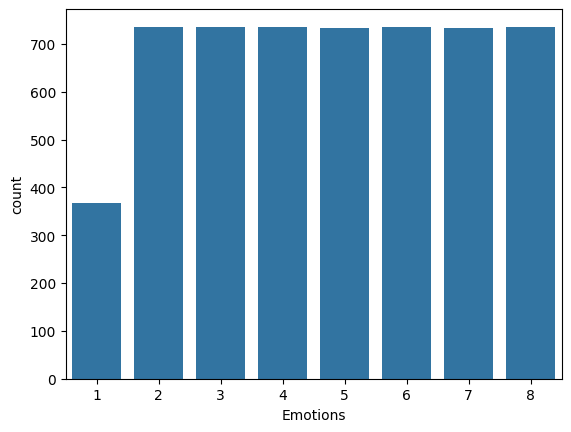

In [9]:
sns.countplot(data=Ravdess_df, x='Emotions')

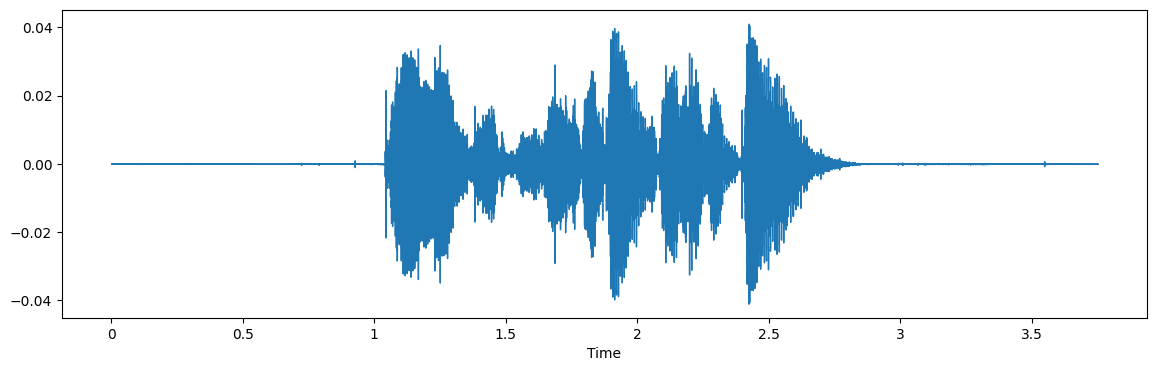

In [10]:
from moviepy.editor import *
path = np.array(Ravdess_df.Path)[15]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

In [11]:
number_to_emotion = {1:'neutral', 2:'calm', 3:'happy', 4 :'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprised'}
emotion_to_number = {'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'pleasant_surprised':8,'surprise':8}

In [12]:
import kagglehub

path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

100%|██████████| 428M/428M [00:04<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [13]:
Tess = "/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
tess_directory_list = os.listdir(Tess)
print(tess_directory_list)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess+'/'+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame([emotion_to_number[x] for x in file_emotion], columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

['OAF_happy', 'OAF_Fear', 'OAF_neutral', 'OAF_Sad', 'YAF_pleasant_surprised', 'YAF_happy', 'OAF_angry', 'YAF_angry', 'YAF_sad', 'YAF_disgust', 'YAF_fear', 'YAF_neutral', 'OAF_Pleasant_surprise', 'OAF_disgust']


In [14]:
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,3,/root/.cache/kagglehub/datasets/ejlok1/toronto...
1,3,/root/.cache/kagglehub/datasets/ejlok1/toronto...
2,3,/root/.cache/kagglehub/datasets/ejlok1/toronto...
3,3,/root/.cache/kagglehub/datasets/ejlok1/toronto...
4,3,/root/.cache/kagglehub/datasets/ejlok1/toronto...


<Axes: xlabel='Emotions', ylabel='count'>

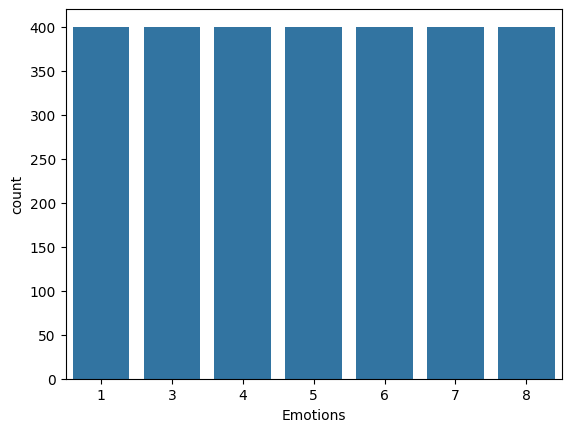

In [15]:
sns.countplot(data=Tess_df, x='Emotions')

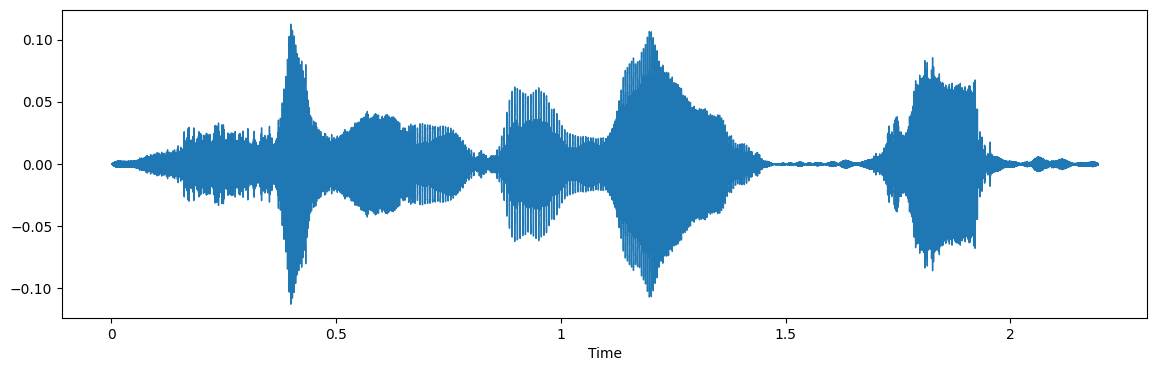

In [16]:
path = np.array(Tess_df.Path)[15]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

In [39]:
data_path = pd.concat([Ravdess_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(8316, 2)

In [18]:
data_path.head()

,Emotions,Path
0,3,/content/gdrive/My Drive/1188976/Video_Speech_...
1,3,/content/gdrive/My Drive/1188976/Video_Speech_...
2,2,/content/gdrive/My Drive/1188976/Video_Speech_...
3,1,/content/gdrive/My Drive/1188976/Video_Speech_...
4,3,/content/gdrive/My Drive/1188976/Video_Speech_...


<Axes: xlabel='Emotions', ylabel='count'>

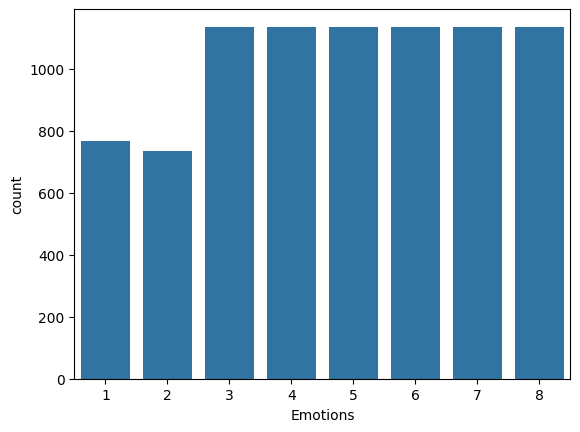

In [19]:
sns.countplot(data=data_path, x='Emotions')

In [20]:
data_path['Emotions'].value_counts()

,count
Emotions,
3,1136
4,1136
8,1136
6,1136
5,1134
7,1134
1,768
2,736


In [21]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

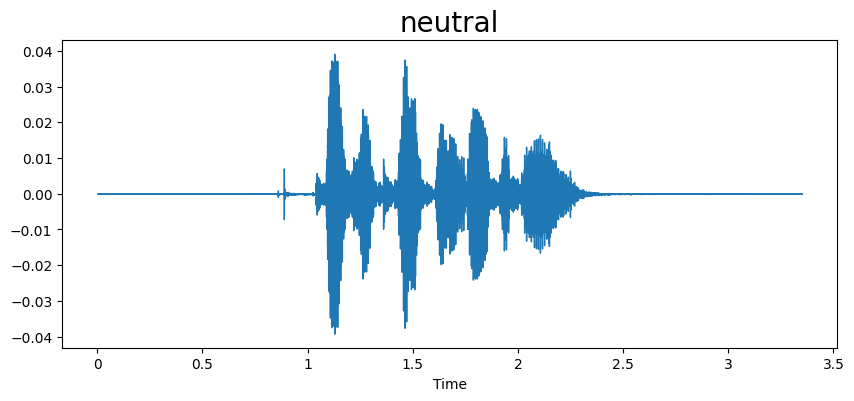

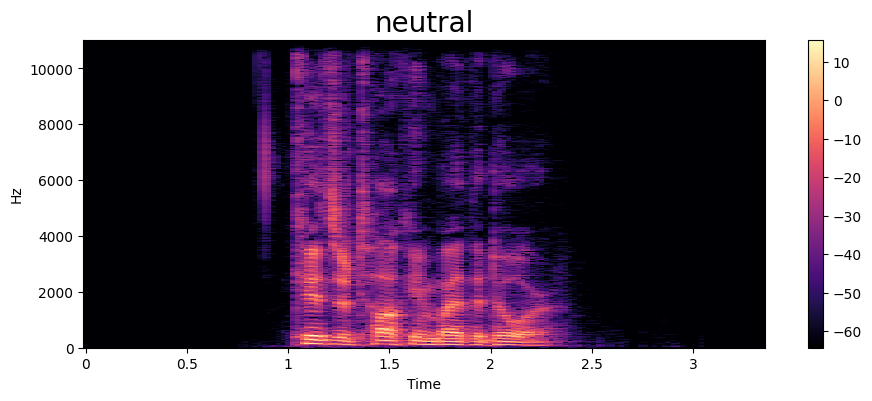

In [22]:
emotion = number_to_emotion[1]
path = np.array(data_path['Path'][data_path['Emotions']== 1 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

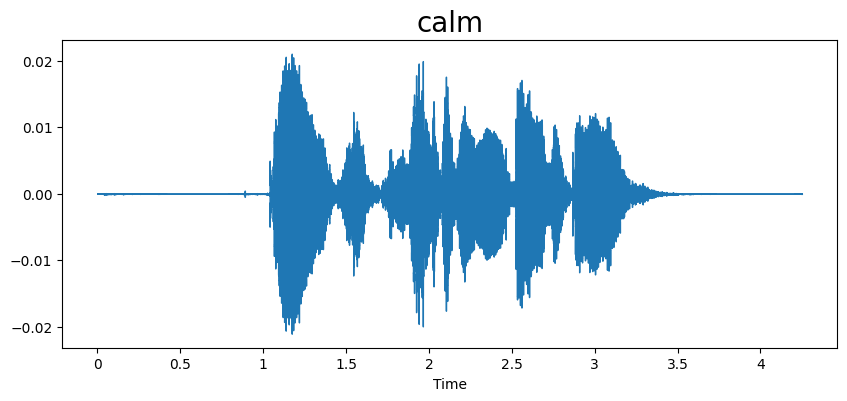

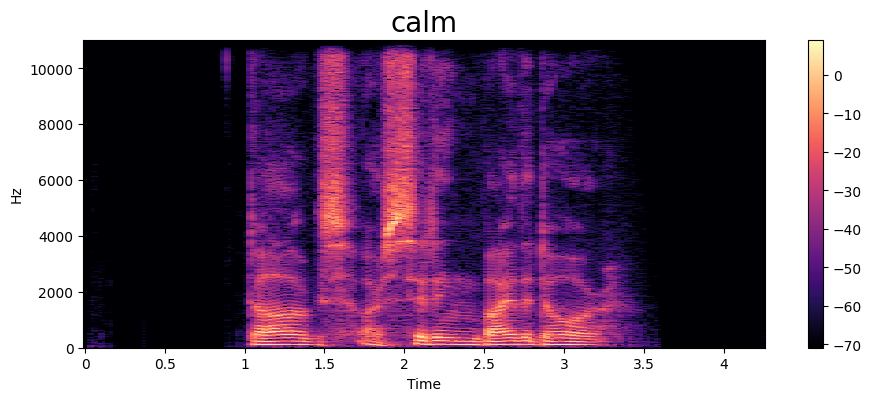

In [23]:
emotion = number_to_emotion[2]
path = np.array(data_path['Path'][data_path['Emotions']== 2 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

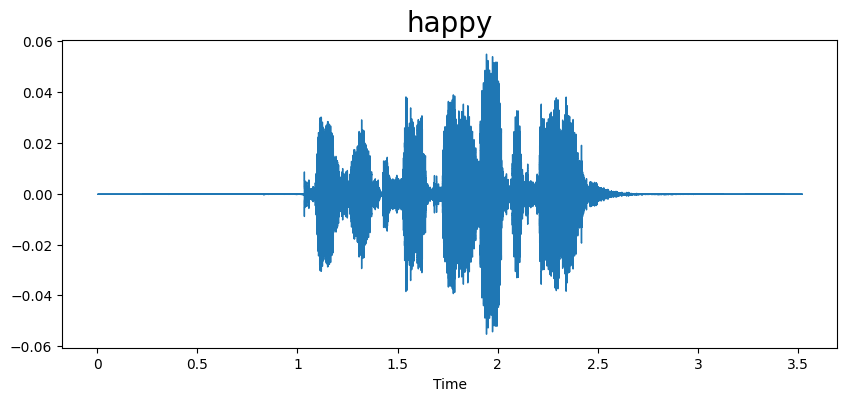

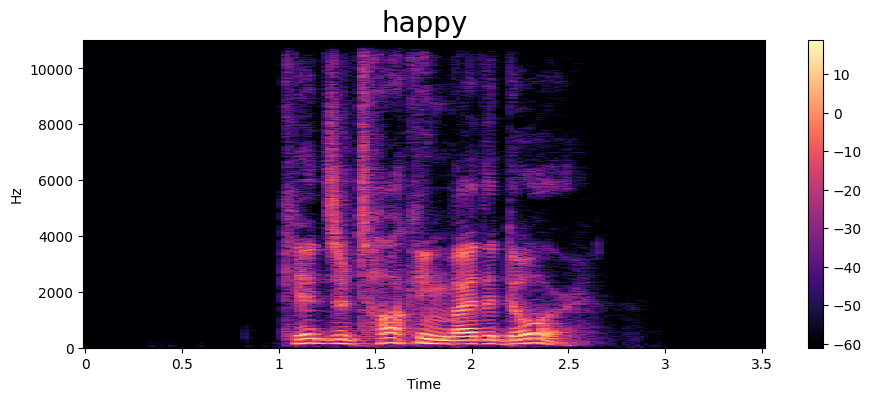

In [24]:
emotion = number_to_emotion[3]
path = np.array(data_path['Path'][data_path['Emotions']== 3 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

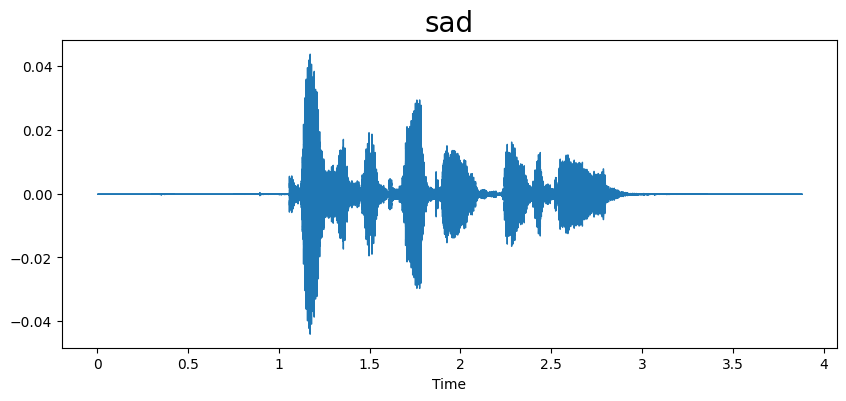

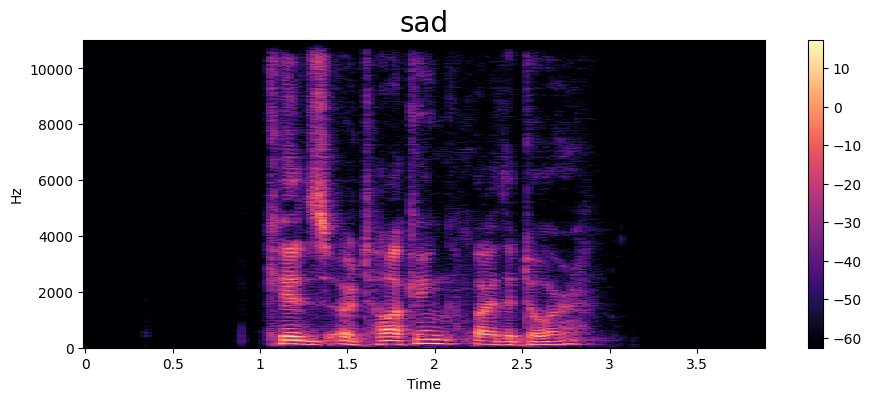

In [25]:
emotion = number_to_emotion[4]
path = np.array(data_path['Path'][data_path['Emotions']== 4 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

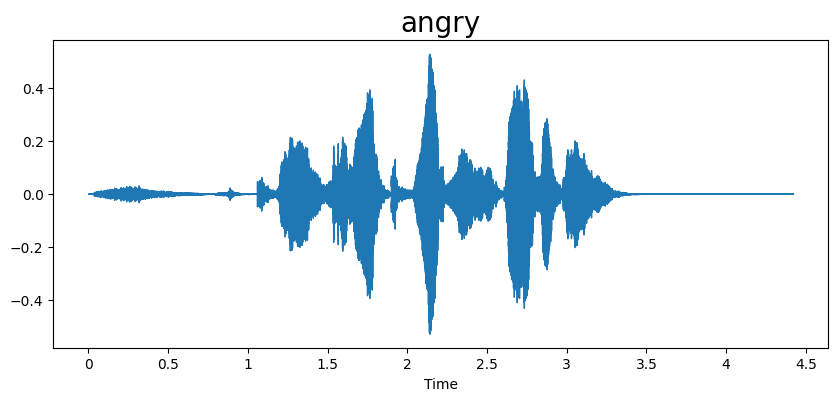

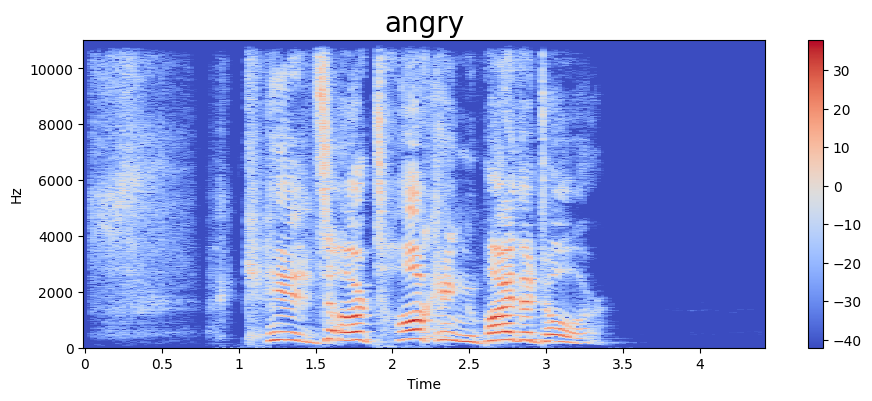

In [26]:
emotion = number_to_emotion[5]
path = np.array(data_path['Path'][data_path['Emotions']== 5 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

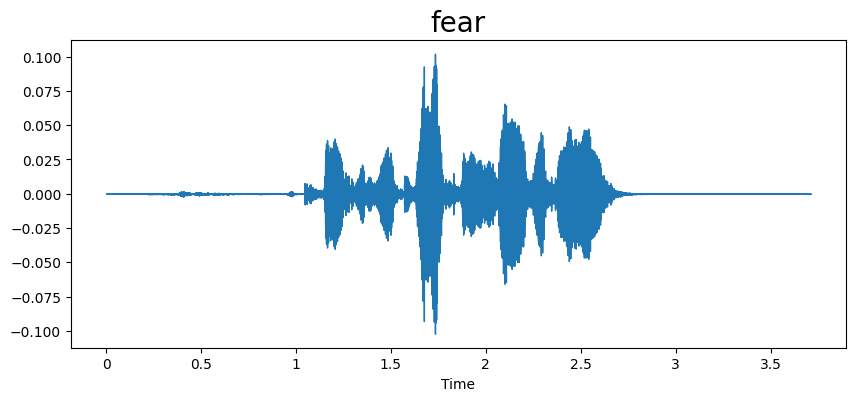

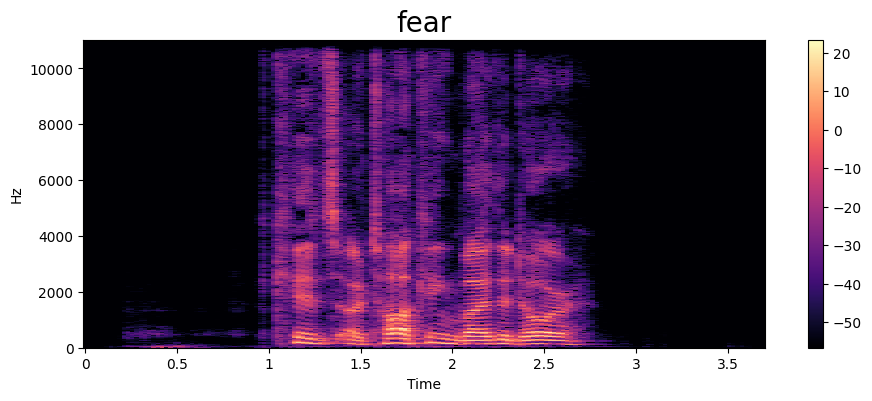

In [27]:
emotion = number_to_emotion[6]
path = np.array(data_path['Path'][data_path['Emotions']== 6 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

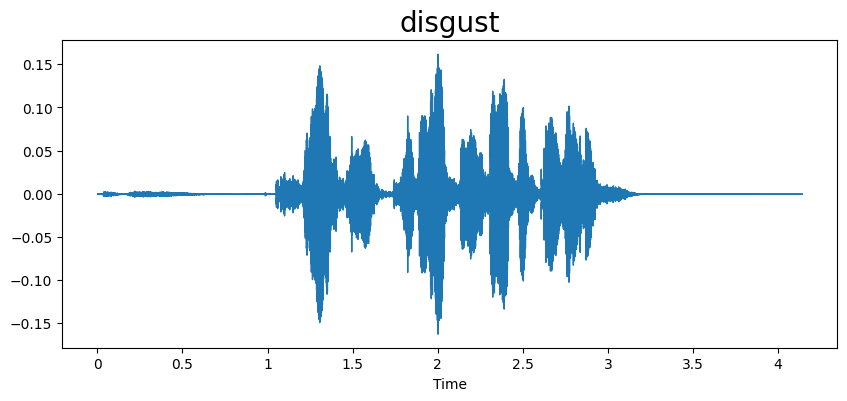

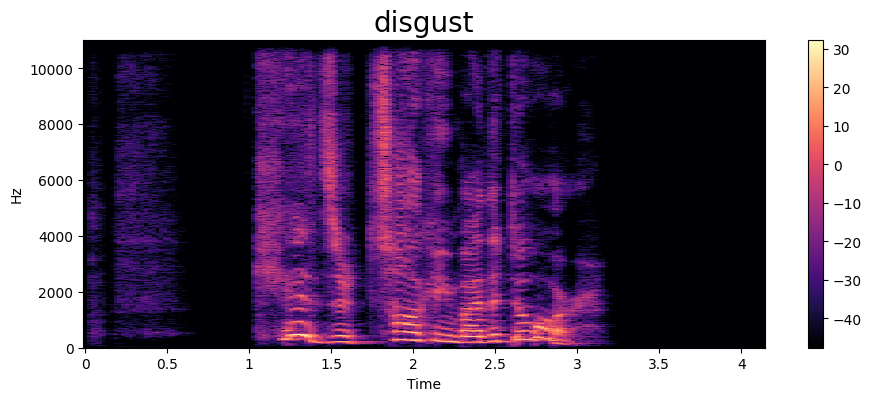

In [28]:
emotion = number_to_emotion[7]
path = np.array(data_path['Path'][data_path['Emotions']== 7 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

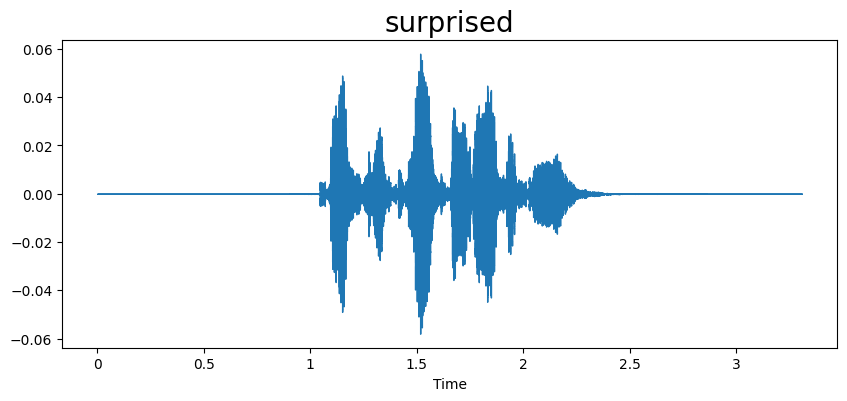

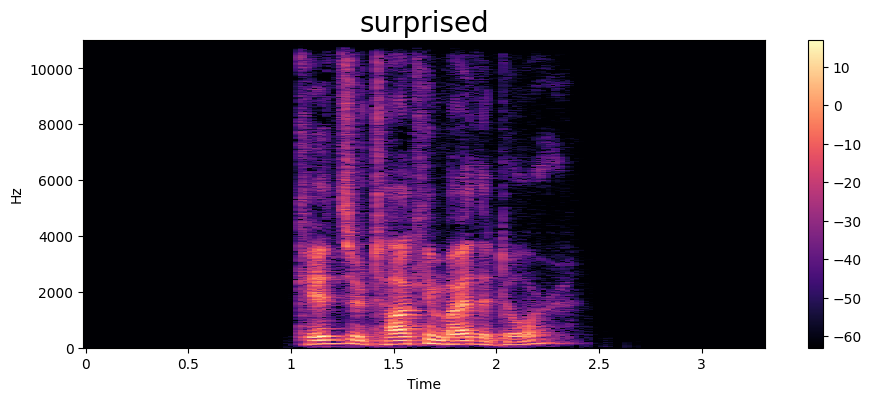

In [29]:
emotion = number_to_emotion[8]
path = np.array(data_path['Path'][data_path['Emotions']== 8 ])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

<Axes: xlabel='Emotions', ylabel='count'>

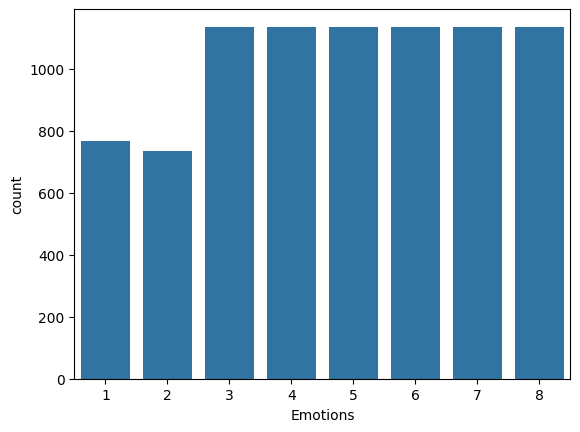

In [30]:
sns.countplot(data=data_path, x='Emotions')

## Data Preprocessing
This section covers preprocessing steps such as handling missing values and normalizing audio features. Preprocessing ensures that the data is clean and ready for feature extraction and model training.

In [41]:
print(data_path['Emotions'].value_counts())

Emotions
3    1136
4    1136
6    1136
8    1136
5    1134
7    1134
1     768
2     736
Name: count, dtype: int64


In [40]:
emotions_to_reduce = [3,4,5,6,7,8]
reduced_data = (
    data_path[data_path['Emotions'].isin(emotions_to_reduce)]
)
other_data = data_path[~data_path['Emotions'].isin(emotions_to_reduce)]

# Combine the reduced emotions and the other emotions
data_path = pd.concat([reduced_data, other_data], ignore_index=True)

In [42]:
neutral_data = data_path[data_path['Emotions'] == 1]
duplicates_needed = 1136 - len(neutral_data)
neutral_augmented = neutral_data.sample(duplicates_needed, replace=True, random_state=42)

# Combine the original and duplicated 'neutral' data
balanced_neutral_data = pd.concat([neutral_data, neutral_augmented])

# Combine all the balanced data
data_path = pd.concat([reduced_data, balanced_neutral_data])

In [43]:
print(data_path['Emotions'].value_counts())

Emotions
3    1136
4    1136
6    1136
8    1136
1    1136
5    1134
7    1134
Name: count, dtype: int64


Here, we preprocess the audio data to prepare it for machine learning models. This involves:

- Loading each audio file using `librosa`, a library for audio analysis.
- Extracting features such as Mel-frequency cepstral coefficients (MFCCs), which are commonly used in speech and audio processing tasks.
- Normalizing these features to ensure that each feature contributes equally to the analysis.

Preprocessing is a crucial step as it transforms raw audio data into a format suitable for model training.

In [44]:
def extract_features(data, sample_rate):
    result = torch.tensor([]).to('cuda')  # Start with an empty tensor on GPU

    # ZCR
    zcr = torch.tensor(librosa.feature.zero_crossing_rate(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, zcr), dim=0)  # Concatenate on GPU

    # Chroma_stft
    stft = torch.tensor(np.abs(librosa.stft(data))).to('cuda')
    chroma_stft = torch.tensor(librosa.feature.chroma_stft(S=stft.cpu().numpy(), sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, chroma_stft), dim=0)

    # MFCC
    mfcc = torch.tensor(librosa.feature.mfcc(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mfcc), dim=0)

    # Root Mean Square Value
    rms = torch.tensor(librosa.feature.rms(y=data).mean(axis=1)).to('cuda')
    result = torch.cat((result, rms), dim=0)

    # MelSpectogram
    mel = torch.tensor(librosa.feature.melspectrogram(y=data, sr=sample_rate).mean(axis=1)).to('cuda')
    result = torch.cat((result, mel), dim=0)

    return result.cpu().numpy()

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Function for stretching the audio
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=rate)

# Function for shifting the audio
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Function for adding pitch to audio
def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor*12)

In [45]:
import random
def augment_and_extract_features(path, n_augment=100):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features from the original audio
    original_features = extract_features(data, sample_rate)
    should_augment = random.choices([0, 1], weights = [1,0])
    if should_augment[0] == 1:
      augmentation_methods = [noise, stretch, shift, pitch]
      method = random.choice(augmentation_methods)

      # Apply the chosen augmentation
      if method == pitch:
          augmented_data = method(data, sample_rate, pitch_factor=np.random.uniform(-1.5, 1.5))
      elif method == stretch:
          augmented_data = method(data, rate=np.random.uniform(0.5, 1.5))
      else:
          augmented_data = method(data)

      # Extract features from the augmented audio
      augmented_features = extract_features(augmented_data, sample_rate)


    # Stack original and augmented features vertically
    return np.vstack(np.array(original_features)).T

In [46]:
X_feat=[]
Y_feat=[]
for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = augment_and_extract_features(path)

    for feature in features:
        X_feat.append(feature)
        Y_feat.append(emotion)

X = np.array(X_feat)
Y = np.array(Y_feat)
# Shuffle the dataset
X, Y = shuffle(X, Y, random_state=42)

In [47]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.152326,0.723500,0.753558,0.625608,0.667693,0.689267,0.694667,0.689269,0.632573,0.629666,...,0.000031,0.000041,0.000070,0.000058,0.000056,0.000047,0.000037,0.000024,0.000002,3
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
2,0.242829,0.637666,0.626383,0.658901,0.678741,0.607893,0.543703,0.546272,0.533975,0.548751,...,0.002023,0.002419,0.002093,0.003948,0.006015,0.007098,0.010487,0.008636,0.000749,7
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
4,0.159492,0.592986,0.571644,0.507923,0.483867,0.474533,0.501707,0.571861,0.638738,0.602473,...,0.000053,0.000190,0.000160,0.000053,0.000035,0.000052,0.000099,0.000050,0.000003,8


In [48]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In this step, we encode the emotion labels using one-hot encoding. This process converts categorical labels into a binary matrix representation, which is required for training neural networks. One-hot encoding ensures that each emotion is represented as a unique vector, facilitating accurate model learning.

In [49]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [50]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5563, 162), (5563, 7), (2385, 162), (2385, 7))

In [51]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5563, 162), (5563, 7), (2385, 162), (2385, 7))

In [52]:
y_train[0:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

### K-Nearest Neighbors (KNN) Model

The KNN model is a simple, instance-based learning algorithm used for classification tasks. It classifies data points based on the majority class of its nearest neighbors. We chose KNN because it is easy to implement and interpret, and it works well with smaller datasets.

**Parameters:**
- `n_neighbors`: This parameter specifies the number of neighbors to consider for classification. A smaller number can lead to overfitting, while a larger number can cause underfitting.
- `weights`: Determines how the distance of neighbors influences their voting power. Common options are 'uniform' (all neighbors have equal weight) and 'distance' (closer neighbors have more influence).

**Results:**
The KNN model provided a baseline accuracy, serving as a comparison point for more complex models. It highlighted the importance of feature scaling and dimensionality reduction in improving performance.

In [54]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [55]:
y_pred=clf1.predict(x_test)

In [56]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.657
Test set score: 0.596


In [57]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-Score:", f1)

Precision: 0.7998823153782361
Recall: 0.6276729559748427
Accuracy: 0.6276729559748427
F1-Score: 0.6600373728910922


In [58]:
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Create a DataFrame from the classification report
df_report = pd.DataFrame(report).transpose()

# Display the DataFrame as a table
df_report

,precision,recall,f1-score,support
0,0.316183,0.976879,0.477739,346.000000
1,0.864253,0.558480,0.678508,342.000000
2,0.893617,0.600000,0.717949,350.000000
3,0.904545,0.580175,0.706927,343.000000
4,0.902326,0.555874,0.687943,349.000000
5,0.915423,0.555891,0.691729,331.000000
6,0.808036,0.558642,0.660584,324.000000
accuracy,0.627673,0.627673,0.627673,0.627673
macro avg,0.800626,0.626563,0.660197,2385.000000
weighted avg,0.799882,0.627673,0.660037,2385.000000


### Vanilla Multi-Layer Perceptron (MLP) Model

The MLP model is a type of feedforward artificial neural network that consists of multiple layers of nodes. It is used for supervised learning tasks and can capture non-linear relationships in data.

**Parameters:**
- `hidden_layer_sizes`: Specifies the number of neurons in each hidden layer. More neurons can capture more complex patterns but may lead to overfitting.
- `activation`: The activation function used in the hidden layers, such as 'relu' or 'tanh', which introduces non-linearity into the model.
- `solver`: The optimization algorithm used for weight updates, such as 'adam' or 'sgd'.

**Results:**
The Vanilla MLP showed improved accuracy over KNN by capturing non-linear relationships in the data. However, it required careful tuning of hyperparameters to avoid overfitting and achieve optimal performance.

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [60]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [61]:
y_pred=model.predict(x_test)

In [62]:

y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Create a DataFrame from the classification report
df_report = pd.DataFrame(report).transpose()

# Display the DataFrame as a table
df_report

,precision,recall,f1-score,support
0,0.306050,0.994220,0.468027,346.000000
1,0.943662,0.587719,0.724324,342.000000
2,0.967593,0.597143,0.738516,350.000000
3,0.969432,0.647230,0.776224,343.000000
4,0.971831,0.593123,0.736655,349.000000
5,0.969388,0.574018,0.721063,331.000000
6,0.958763,0.574074,0.718147,324.000000
accuracy,0.653669,0.653669,0.653669,0.653669
macro avg,0.869531,0.652504,0.697565,2385.000000
weighted avg,0.868123,0.653669,0.697201,2385.000000


In [63]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-Score:", f1)

Precision: 0.868123211879068
Recall: 0.6536687631027254
Accuracy: 0.6536687631027254
F1-Score: 0.6972014442875604


### Convolutional Neural Network (CNN) Model

CNNs are deep learning models particularly effective for processing grid-like data such as images and audio spectrograms. They use convolutional layers to automatically learn spatial hierarchies of features.

**Parameters:**
- `Conv1D` layers: These layers apply convolutional operations to extract local patterns from input data.
- `filters`: Number of output filters in the convolution. More filters allow capturing more features but increase computational cost.
- `kernel_size`: Size of the convolution window, which affects the granularity of feature extraction.
- `Dropout`: Regularization technique to prevent overfitting by randomly setting a fraction of input units to zero during training.

**Results:**
The CNN model achieved higher accuracy than previous models by effectively capturing temporal patterns in audio data through its convolutional layers. It demonstrated the importance of feature extraction capabilities inherent in CNN architectures.

In [64]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

In [65]:
from keras.callbacks import ModelCheckpoint

# Define where to save the best model
checkpoint_filepath = 'best_model.keras'

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # Monitor validation loss
    mode='min',          # Save when val_loss decreases
    save_best_only=True, # Only keep the best model
    verbose=1            # Print messages when saving
)

In [66]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import Adam


# Define model architecture
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',
                 input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.15))
# model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.15))
# model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=7, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 41, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          43,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,799 (975.78 KB)

 Trainable params: 249,799 (975.78 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Compile with a lower learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=150,
                    batch_size=32,
                    callbacks=[model_checkpoint])

Epoch 1/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2119 - loss: 2.4481
Epoch 1: val_loss improved from inf to 2.17521, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.2121 - loss: 2.4475 - val_accuracy: 0.3413 - val_loss: 2.1752
Epoch 2/150
172/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3341 - loss: 2.1137
Epoch 2: val_loss improved from 2.17521 to 1.98634, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3343 - loss: 2.1130 - val_accuracy: 0.3807 - val_loss: 1.9863
Epoch 3/150
173/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3746 - loss: 1.9653
Epoch 3: val_loss improved from 1.98634 to 1.85728, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3748 - loss: 1.9648 - val_accuracy: 0.4113 - val_loss: 1.8573
Epoch 4/150
163/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4286 - loss: 1.8172
Epoch 4: val_loss improved from 1.85728 to 1.75

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6706 - loss: 0.8933
Accuracy of our model on test data :  65.32495021820068 %


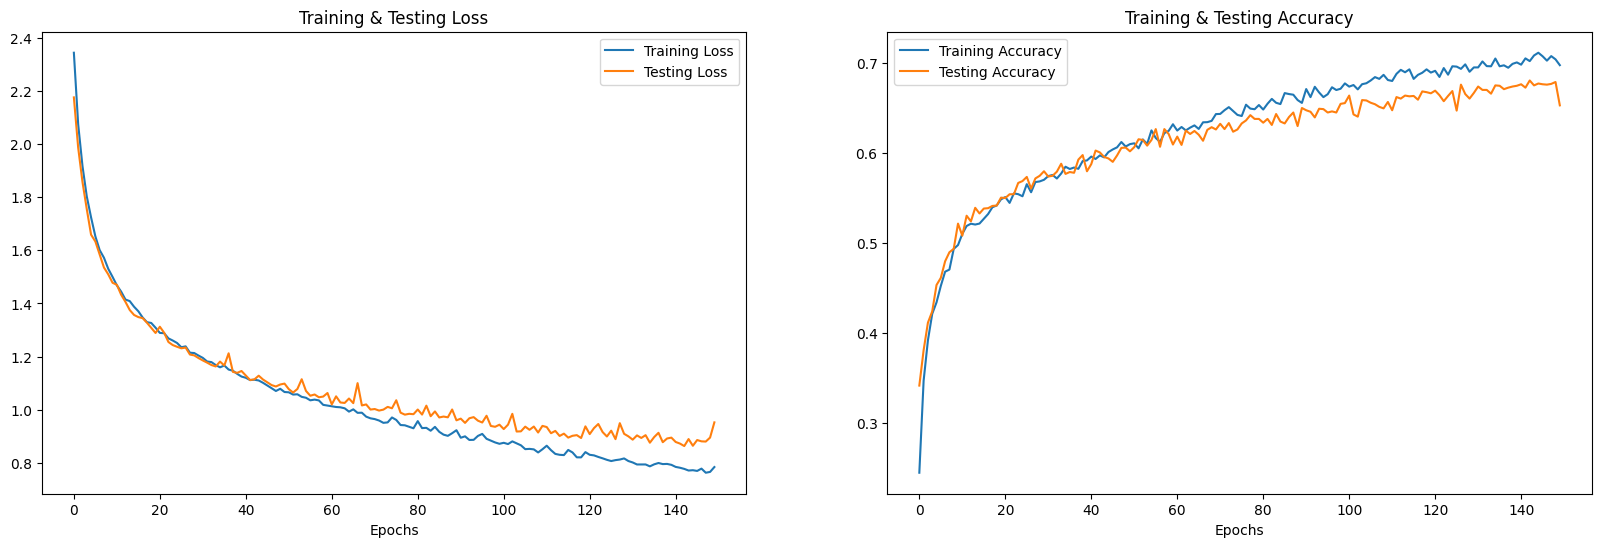

In [68]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
import seaborn as sns
import matplotlib.pyplot as plt
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [69]:
model.load_weights(checkpoint_filepath)
y_pred = model.predict(x_test)
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Create a DataFrame from the classification report
df_report = pd.DataFrame(report).transpose()

# Display the DataFrame as a table
df_report

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,precision,recall,f1-score,support
0,0.934256,0.780347,0.850394,346.000000
1,0.323899,0.903509,0.476852,342.000000
2,0.912664,0.597143,0.721934,350.000000
3,0.966667,0.676385,0.795883,343.000000
4,0.907563,0.618911,0.735945,349.000000
5,0.889908,0.586103,0.706740,331.000000
6,0.894009,0.598765,0.717190,324.000000
accuracy,0.680922,0.680922,0.680922,0.680922
macro avg,0.832709,0.680166,0.714991,2385.000000
weighted avg,0.832697,0.680922,0.715358,2385.000000


In [70]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-Score:", f1)

Precision: 0.8326973904148739
Recall: 0.6809224318658281
Accuracy: 0.6809224318658281
F1-Score: 0.7153584988517282


### CNN + LSTM Model

This hybrid model combines CNNs with Long Short-Term Memory (LSTM) networks to leverage both spatial and temporal features in sequential data. CNNs handle feature extraction, while LSTMs capture temporal dependencies.

**Parameters:**
- `LSTM` layers: These recurrent layers are designed to remember information across long sequences, crucial for time-series data like audio.
- `units`: Number of LSTM units, which determines the capacity to capture temporal dependencies.
- `return_sequences`: If set to True, returns the full sequence output; otherwise, only returns the last output.

**Results:**
The CNN + LSTM model provided superior performance by effectively modeling both spatial and temporal aspects of audio data. It demonstrated significant improvements in capturing complex patterns necessary for emotion recognition tasks.

In [71]:
x_train =np.expand_dims(x_train, axis=2)
x_test= np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5563, 162, 1), (5563, 7), (2385, 162, 1), (2385, 7))

In [83]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

model = Sequential()

# First Convolutional Block
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(BatchNormalization())  # Batch normalization after Conv1D
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.15))  # Increased dropout for regularization

# Second Convolutional Block
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.15))

# LSTM Layer
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
# Fully Connected Layers
model.add(Dense(32, activation='relu'))


model.add(Dense(32, activation='relu'))


# Output Layer
model.add(Dense(7, activation='softmax'))

# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Slightly increased learning rate for faster convergence
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 162, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 81, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 81, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 81, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 41, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 41, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,775 (799.90 KB)

 Trainable params: 204,775 (799.90 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

from keras.callbacks import ReduceLROnPlateau

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.25,
#     patience=10,
#     min_lr=1e-6,
#     verbose=1
# )

history = model.fit(x_train, y_train, batch_size=32, epochs=150,
                    validation_data=(x_test, y_test), callbacks=[model_checkpoint])

model.load_weights(checkpoint_filepath)

Epoch 1/150
173/174 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1721 - loss: 1.8936
Epoch 1: val_loss improved from inf to 1.78735, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1725 - loss: 1.8931 - val_accuracy: 0.2545 - val_loss: 1.7873
Epoch 2/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2694 - loss: 1.7535
Epoch 2: val_loss improved from 1.78735 to 1.67873, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2695 - loss: 1.7534 - val_accuracy: 0.3010 - val_loss: 1.6787
Epoch 3/150
171/174 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3271 - loss: 1.6246
Epoch 3: val_loss improved from 1.67873 to 1.52682, saving model to best_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3270 - loss: 1.6244 - val_accuracy: 0.3530 - val_loss: 1.5268
Epoch 4/150
171/174 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3596 - loss: 1.5266
Epoch 4: val_loss improved from 1.52682 to 

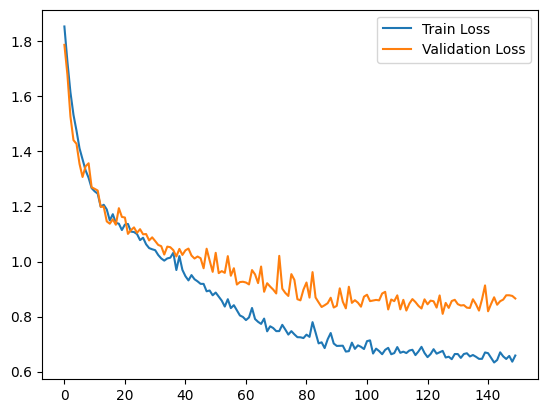

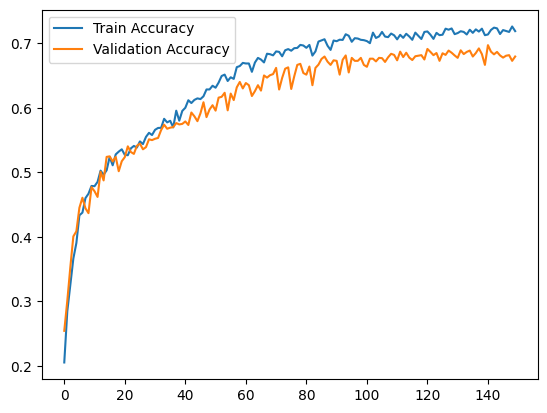

In [85]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [86]:
model.load_weights(checkpoint_filepath)
y_pred = model.predict(x_test)
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Create a DataFrame from the classification report
df_report = pd.DataFrame(report).transpose()

# Display the DataFrame as a table
df_report

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,precision,recall,f1-score,support
0,0.985348,0.777457,0.869144,346.000000
1,0.930556,0.587719,0.720430,342.000000
2,0.919831,0.622857,0.742760,350.000000
3,0.927711,0.673469,0.780405,343.000000
4,0.911017,0.616046,0.735043,349.000000
5,0.915493,0.589124,0.716912,331.000000
6,0.316337,0.938272,0.473152,324.000000
accuracy,0.684696,0.684696,0.684696,0.684696
macro avg,0.843756,0.686421,0.719692,2385.000000
weighted avg,0.848131,0.684696,0.721964,2385.000000


In [87]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-Score:", f1)

Precision: 0.8481310150767942
Recall: 0.6846960167714885
Accuracy: 0.6846960167714885
F1-Score: 0.7219642361515064


### Conclusion

In this project, we investigated emotion recognition from audio data using both the RAVDESS and TESS datasets. By employing a variety of machine learning models, we aimed to identify the most effective approach for classifying emotions.

**Datasets Used:**
- **RAVDESS**: A dataset containing emotional speech and song recordings.
- **TESS**: A dataset with recordings of two actresses speaking the same set of phrases in seven different emotions.

**Models and Results:**
- **K-Nearest Neighbors (KNN)**: As a baseline, KNN provided an initial understanding of the dataset's structure. However, its performance was limited due to its simplicity. The F1 score for KNN was relatively low, indicating room for improvement with more complex models.
  
- **Vanilla Multi-Layer Perceptron (MLP)**: This model improved upon KNN by capturing non-linear relationships in the data. The F1 score showed a moderate increase, reflecting better handling of complex patterns compared to KNN.

- **Convolutional Neural Network (CNN)**: The CNN model significantly enhanced performance by effectively extracting spatial features from audio spectrograms. Its F1 score was notably higher than both KNN and MLP, demonstrating its capability in emotion recognition tasks.

- **CNN + LSTM**: This hybrid model combined the strengths of CNNs and LSTMs to capture both spatial and temporal dependencies in audio data. It achieved the highest F1 score among all models, highlighting its effectiveness in modeling complex audio features essential for accurate emotion classification.

Through this comprehensive analysis, we demonstrated the importance of selecting appropriate models based on data characteristics and task requirements. The deep learning models, particularly CNN and CNN + LSTM, showcased their superior ability to handle complex audio features, making them ideal for emotion recognition tasks. Future work could focus on further optimizing these models and exploring additional feature extraction techniques to enhance performance.